 # Frozen Lake, Not Slippery
    
    In this notebook, we implement 3 RL algorithms: Q-Learning, SARSA, and Cross-Entropy. For each one, we produce multiple plots of average rewards vs num of episodes comparing various paraters.

# Setup


In [111]:
import numpy
import collections
import gym
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


## Some Function Definitions

In [62]:
def get_action( state, q_values, epsilon):
    """
    Select an action from [0,1,2,3] (representing ["Left", "Down", "Right", "Up"] using epsilon-greedy.
    :param state: the state of interest
    :param q_values: a map of q_values.
    :param epsilon: probability of using a uniform distribution to select an action
    
    :return: an action
    """
    # Extract the action values.
    action_values = [q_values[(state, 0)], q_values[(state, 1)],q_values[(state, 2)], q_values[(state, 3)]]

    # Then initialize their probabilities as uniform over epsilon.
    action_probs = [epsilon/4, epsilon/4, epsilon/4, epsilon/4]

    # Find the max action value's index, then add (1-epsilon) to its probability.
    maxqsa = max(action_values)

    # if the maximum is 0.0, then all values are still 0.0, therefore force a uniform distribution..
    if maxqsa == 0.0:
        action_probs = [0.25, 0.25, 0.25, 0.25]
    else:
        action = action_values.index(maxqsa)
        action_probs[action] = action_probs[action] + 1-epsilon

    # sample over the probabilities
    return numpy.random.choice([0, 1, 2, 3], p=action_probs )


In [63]:
def get_max_Q(state, q_values):
    """ Given a state, return the max Qvalue among all the actions
    :param state: the state of interest
    :param q_values: a dict with keys as (s,a) and values as q_values.
    :return: max Qvalue among all the actions
    """
    state_action_values = [q_values[(state, 0)], q_values[(state, 1)], q_values[(state, 2)], q_values[(state, 3)]]
    maxQsa = max(state_action_values)
    return maxQsa

In [64]:
def update_ave_rewards(ave_rewards, episode, rewards):
    """
    This function is used to update average rewards per episode.
    The ave_rewards is an array contains a list of successive ave rewards vs num_episodes.
    parameter episode is the index of the ith episode. Therefore its entry will be the average of the (episode-1)th average
    muliplied by (episode-1) then adding rewards, then dividing by episode. Need to figure out zero-indexing.

    :param ave_rewards: a list as described above. The value of  the index is the num of (episodes+1), and the value contains
        the average of rewards across those episodes
    :param episode: the episode index: int
    :param rewards: the scalar reward
    :return: None
    """
    assert episode == len(ave_rewards), "Episode:{} should equal len(ave_rewards):{}".format(episode, len(ave_rewards))
    if episode == 0:
        ave_rewards.append(rewards)
    else:
        reward_sum = ave_rewards[episode-1] * (episode-1)
        reward_sum += rewards
        reward_ave = reward_sum / episode
        ave_rewards.append(reward_ave)


### Q-Learning main algorithm

In [98]:
def q_learn(env, num_episodes, gamma, alpha, epsilon):
    """
    This implements the Q-Learning algorithm.
    :param env_name: The environment
    :param num_episodes: Num of episodes to iterate over.
    :param gamma: the discount parameter for computing rewards
    :param alpha: the learning rate
    :param epsilon: Epsilon parameter for epsilon-greedy action selection.
    :return: an array of average_rewards
    """

    Q_values = collections.defaultdict(float)  # dict of (state,action):value
    actions = {}  # dict of episode:[actions]
    rewards = {}  # dict of episode: total rewards for tha episode
    ave_rewards = []  # array of  ave rewards across all episodes until episode index
    nonzero_states = []  # array of non-zero states. index is episode.

    for i_episode in range(num_episodes):
        state = env.reset()  # Initialize S
        actions[i_episode] = []
        rewards[i_episode] = 0.0
        done = False
        while not done:  # Loop until end of episode
            action = get_action(state, Q_values, epsilon)  # Choose A from S using policy (e.g. epsilon-greedy)
            actions[i_episode].append(action)
            newstate, reward, done, info = env.step(action)  # Take action A, observe R, S'
            Q_values[(state, action)] = Q_values[(state, action)] + alpha * (
                    reward + gamma * get_max_Q(newstate, Q_values) - Q_values[(state, action)])
            state = newstate
            rewards[i_episode] += reward

        
        update_ave_rewards(ave_rewards, i_episode, rewards[i_episode])
    
    print("Completed Q-Learning run with gamma={}, learning rate={}".format(gamma, alpha))
    return ave_rewards


### SARSA main algorithm

In [105]:
def sarsa(env, num_episodes, gamma, alpha, epsilon):
    """
    This implements the SARSA algorithm.
    :param env_name: the environment
    :param num_episodes: The number of episodes to iterate over.
    :param gamma: The discount parameter for computing rewards
    :param alpha: the learning rate
    :param epsilon: Epsilon parameter for epsilon-greedy action selection.
    
    :return: array of average rewards
    """

    actions = {}  # dict of episode:[actions]
    rewards = {}  # dict of episode: total rewards for tha episode
    ave_rewards = []  # array of  ave rewards across all episodes until episode index


    q_values = collections.defaultdict(float)  # dict of (state,action):value
    for i_episode in range(num_episodes):

        state = env.reset()  # Initialize S
        action = get_action(state, q_values, epsilon)  # Choose A from S using policy (e.g. epsilon-greedy)
        actions[i_episode] = []
        actions[i_episode].append(action)
        rewards[i_episode] = 0.0
        done = False
        while not done:  # Repeat for each step of the episode
            newstate, reward, done, info = env.step(action)  # Take action A, observe R, S'
            newaction = get_action(newstate, q_values, epsilon)  # Choose A' from S' using policy (e.g. epsilon-greedy)
            q_values[(state, action)] = q_values[(state, action)] + alpha * (
                    reward + gamma * q_values[(newstate, newaction)] - q_values[(state, action)])
            state = newstate
            action = newaction
            rewards[i_episode] += reward

        update_ave_rewards(ave_rewards, i_episode, rewards[i_episode])
        
        
    print("Completed SARSA Learning run with gamma={}, learning rate={}".format(gamma, alpha))
    return ave_rewards


## Q-Learning

Completed Q-Learning run with gamma=0.1, learning rate=0.1
Completed Q-Learning run with gamma=0.1, learning rate=0.5
Completed Q-Learning run with gamma=0.1, learning rate=0.9
Completed Q-Learning run with gamma=0.5, learning rate=0.1
Completed Q-Learning run with gamma=0.5, learning rate=0.5
Completed Q-Learning run with gamma=0.5, learning rate=0.9
Completed Q-Learning run with gamma=0.9, learning rate=0.1
Completed Q-Learning run with gamma=0.9, learning rate=0.5
Completed Q-Learning run with gamma=0.9, learning rate=0.9


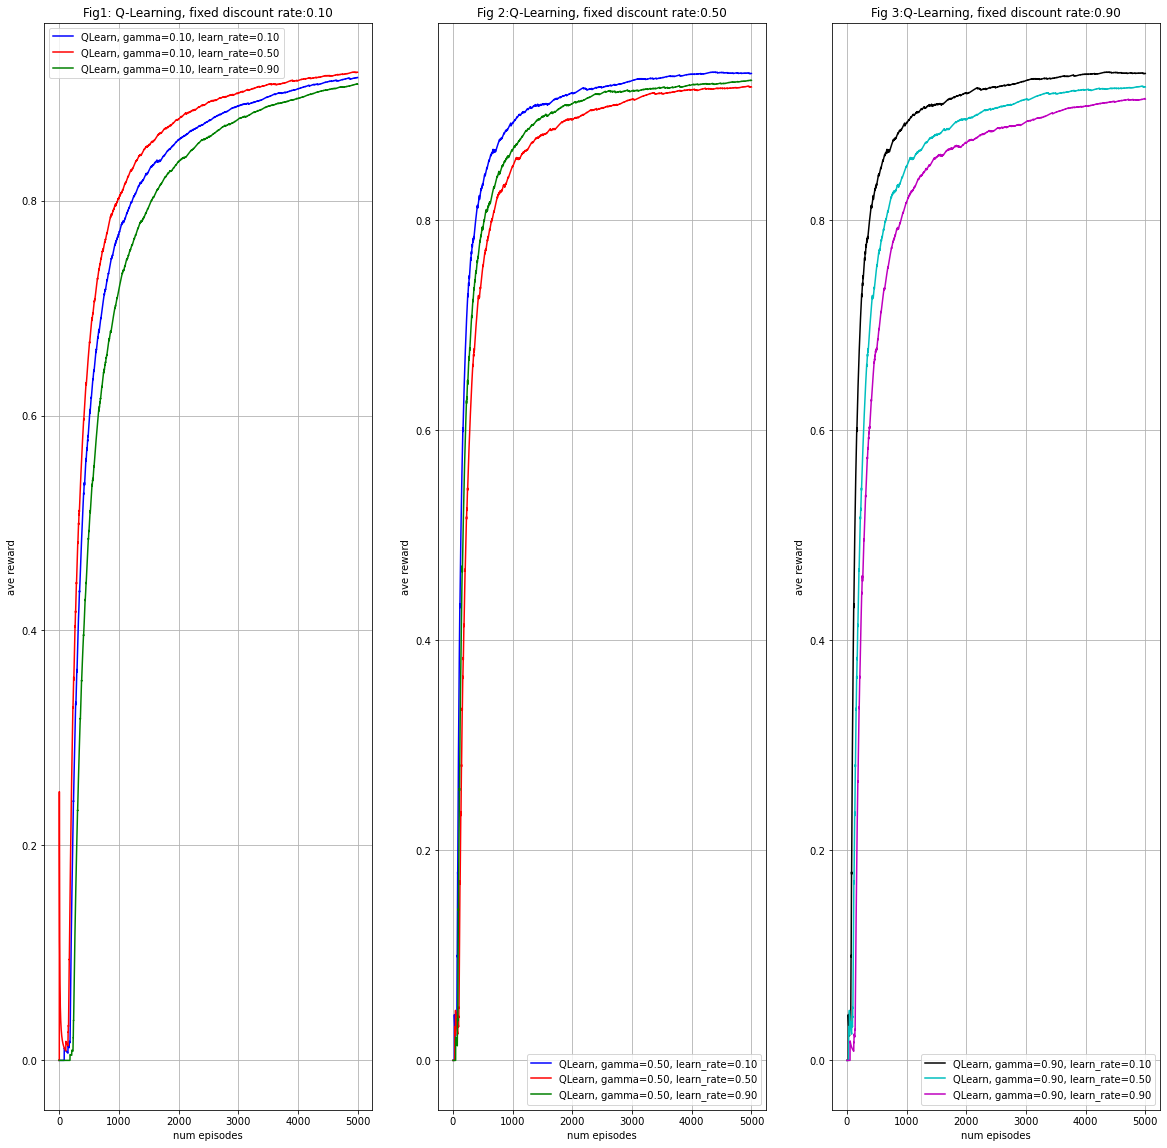

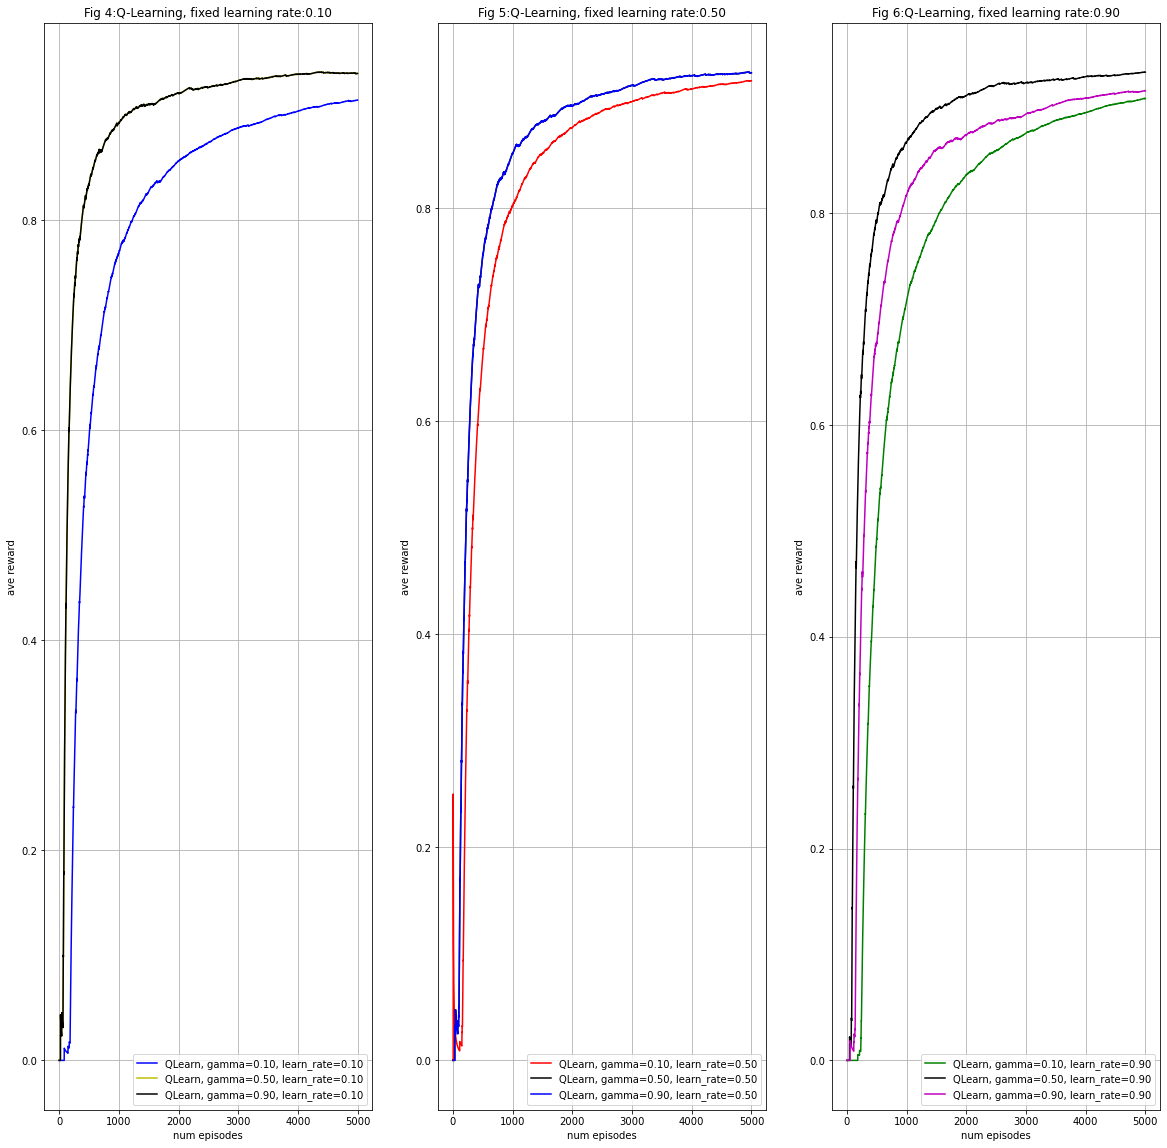

In [102]:

num_episodes = 5000
epsilon = 0.05
#plt.rcParams['figure.figsize'] = [20, 20]
fig1, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
fig2, ((ax4, ax5, ax6)) = plt.subplots(1, 3)    

env = gym.make('FrozenLake-v0', is_slippery=False)
    
gamma = 0.1
alpha = 0.1
q_ave_rewards_1 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_1, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_1, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.1
alpha = 0.5    
q_ave_rewards_2 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_2, 'r', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_2, 'r', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.1
alpha = 0.9
q_ave_rewards_3 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_3, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_3, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha)) 
gamma = 0.5
alpha = 0.1
q_ave_rewards_4 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_4, 'b-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_4, 'y', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.5
alpha = 0.5
q_ave_rewards_5 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_5, 'r-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_5, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.5
alpha = 0.9
q_ave_rewards_6 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_6, 'g-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_6, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))     
gamma = 0.9
alpha = 0.1
q_ave_rewards_7 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_4, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_4, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.9
alpha = 0.5
q_ave_rewards_8 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_5, 'c', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_5, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.9
alpha = 0.9
q_ave_rewards_9 = q_learn(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_9, 'm', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_9, 'm', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))        
ax1.legend()
ax1.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig1: Q-Learning, fixed discount rate:0.10')
ax1.grid()
    
ax2.legend()
ax2.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 2:Q-Learning, fixed discount rate:0.50')
ax2.grid()

ax3.legend()
ax3.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 3:Q-Learning, fixed discount rate:0.90')
ax3.grid()
    
ax4.legend()
ax4.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 4:Q-Learning, fixed learning rate:0.10')
ax4.grid()
ax5.legend()
ax5.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 5:Q-Learning, fixed learning rate:0.50')
ax5.grid()
ax6.legend()
ax6.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 6:Q-Learning, fixed learning rate:0.90')
ax6.grid()


plt.show()
    


### Analysis
Looking at Figs 1-3, for a fixed discount rate (gamma), a high learning rate results in faster learning, except in Figure 3, where the best learning rate was 0.5 (middle value) 
In Figs 4-6, for a fixed learning rate, smaller discount rate seemed to produce the faster learning.

### SARSA

Completed SARSA Learning run with gamma=0.1, learning rate=0.1
Completed SARSA Learning run with gamma=0.1, learning rate=0.5
Completed SARSA Learning run with gamma=0.1, learning rate=0.9
Completed SARSA Learning run with gamma=0.5, learning rate=0.1
Completed SARSA Learning run with gamma=0.5, learning rate=0.5
Completed SARSA Learning run with gamma=0.5, learning rate=0.9
Completed SARSA Learning run with gamma=0.9, learning rate=0.1
Completed SARSA Learning run with gamma=0.9, learning rate=0.5
Completed SARSA Learning run with gamma=0.9, learning rate=0.9


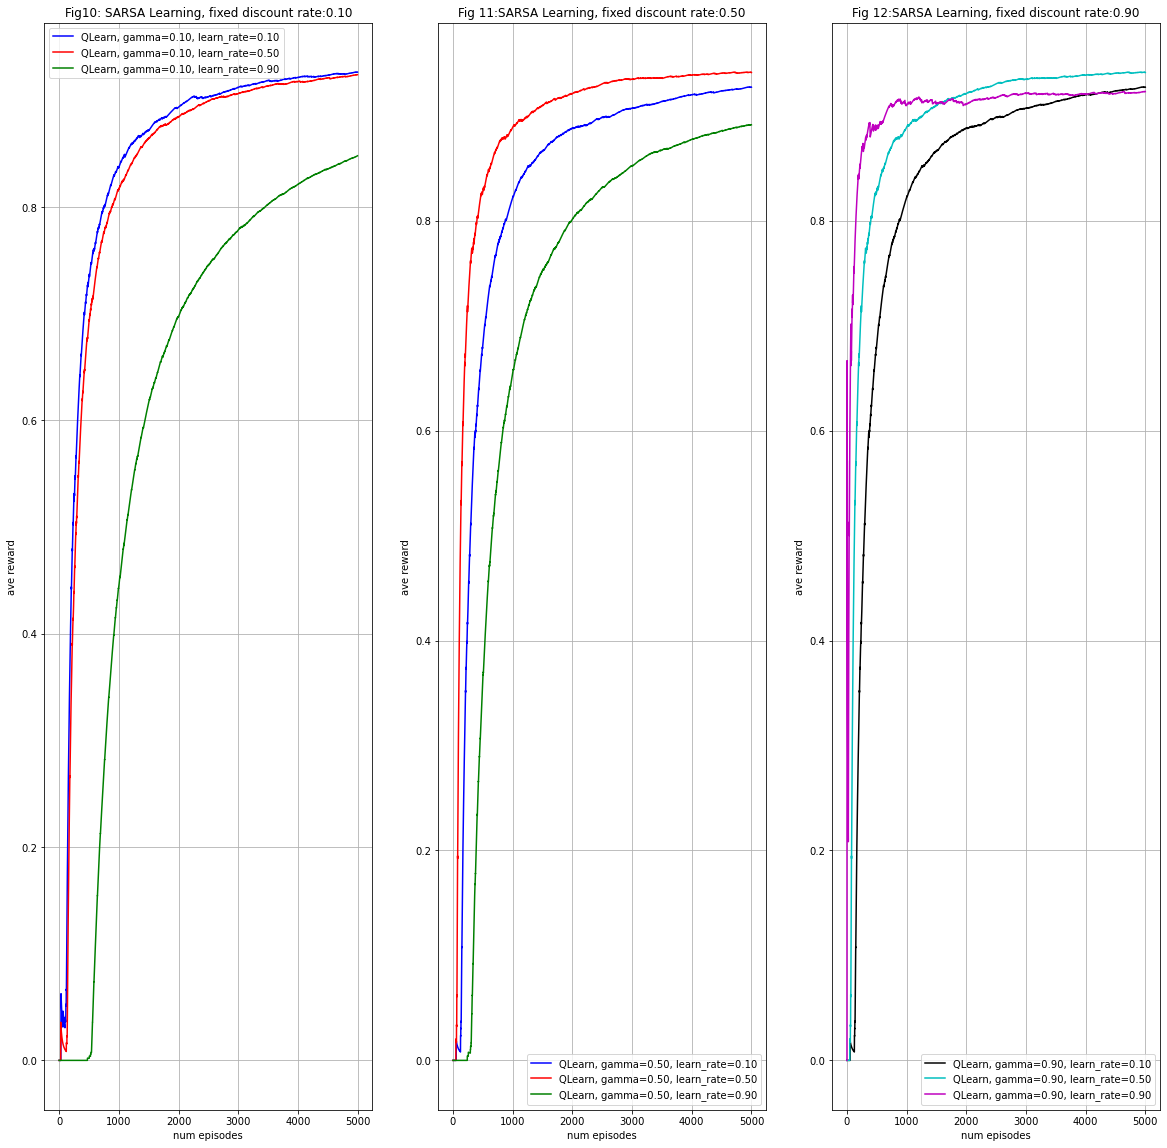

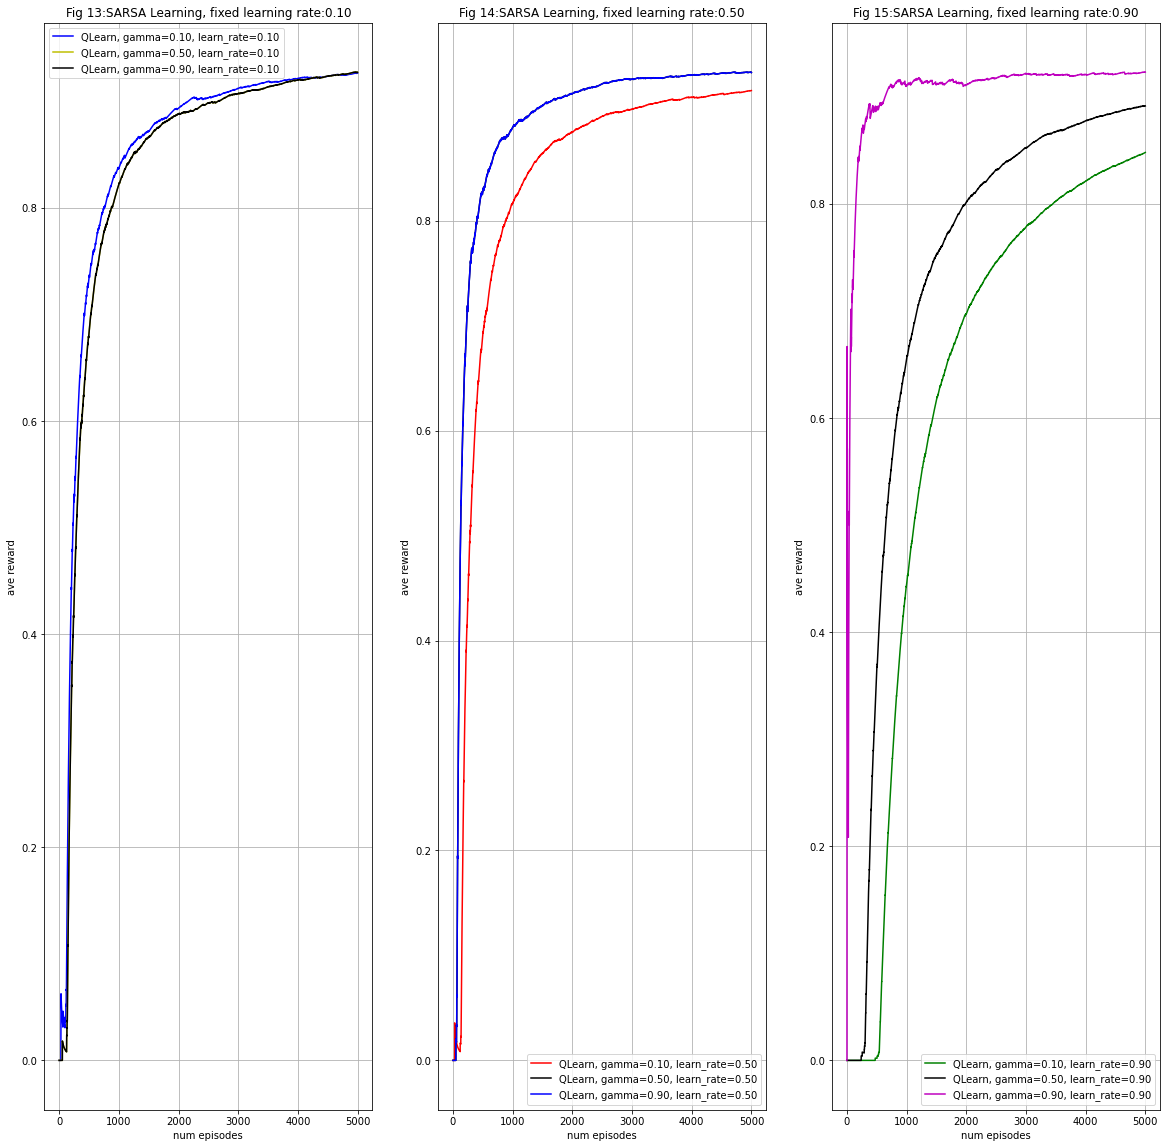

In [107]:
num_episodes = 5000
epsilon = 0.05
#plt.rcParams['figure.figsize'] = [20, 20]
fig1, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
fig2, ((ax4, ax5, ax6)) = plt.subplots(1, 3)    

env = gym.make('FrozenLake-v0', is_slippery=False)
    
gamma = 0.1
alpha = 0.1
q_ave_rewards_1 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_1, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_1, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.1
alpha = 0.5    
q_ave_rewards_2 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_2, 'r', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_2, 'r', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.1
alpha = 0.9
q_ave_rewards_3 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax1.plot(q_ave_rewards_3, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_3, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha)) 
gamma = 0.5
alpha = 0.1
q_ave_rewards_4 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_4, 'b-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_4, 'y', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.5
alpha = 0.5
q_ave_rewards_5 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_5, 'r-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_5, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.5
alpha = 0.9
q_ave_rewards_6 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax2.plot(q_ave_rewards_6, 'g-', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_6, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))     
gamma = 0.9
alpha = 0.1
q_ave_rewards_7 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_4, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax4.plot(q_ave_rewards_4, 'k', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.9
alpha = 0.5
q_ave_rewards_8 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_5, 'c', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax5.plot(q_ave_rewards_5, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
gamma = 0.9
alpha = 0.9
q_ave_rewards_9 = sarsa(env, num_episodes, gamma, alpha, epsilon)
ax3.plot(q_ave_rewards_9, 'm', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
ax6.plot(q_ave_rewards_9, 'm', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))        
ax1.legend()
ax1.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig10: SARSA Learning, fixed discount rate:0.10')
ax1.grid()
    
ax2.legend()
ax2.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 11:SARSA Learning, fixed discount rate:0.50')
ax2.grid()

ax3.legend()
ax3.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 12:SARSA Learning, fixed discount rate:0.90')
ax3.grid()
    
ax4.legend()
ax4.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 13:SARSA Learning, fixed learning rate:0.10')
ax4.grid()
ax5.legend()
ax5.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 14:SARSA Learning, fixed learning rate:0.50')
ax5.grid()
ax6.legend()
ax6.set(xlabel='num episodes', ylabel='ave reward',
        title='Fig 15:SARSA Learning, fixed learning rate:0.90')
ax6.grid()


plt.show()
    

### Analysis
Looking at Figs 10-12, for a fixed discount rate (gamma), a high learning rate results in slowe learning. 
In Figs 13-15, for a fixed learning rate, smaller discount rate seemed to produce the faster learning.

### CROSS ENTROPY

### Some support functions

In [112]:
class OneHotWrapper(gym.ObservationWrapper):
    """
    This is a wrapper class for the environment. So we could create wrapper functions around it.
    """
    def __init__(self, env):
        super(OneHotWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(0.0, 1.0, (env.observation_space.n, ), dtype=np.float32)

    def observation(self, observation):
        r = np.copy(self.observation_space.low)
        r[observation] = 1.0
        return r


class Net(nn.Module):
    """
    This is the neural network to predict policy given state.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        """
        This network has only 1 hidden layer.
        :param obs_size: the size of the observation
        :param hidden_size: the hidden layer size.
        :param n_actions: the number of actions to predict.
        """
        super(Net, self).__init__()
        self.net= nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        """
        Forwarding an input into the layer.
        :param x:
        :return:
        """
        return self.net(x)


def select_action(net, state):
    """
    This selects an action from a given neural network, and input state.
    :param net: The neural network that computes the policy.
    :param state: The input state
    :return: the action
    """
    sm = nn.Softmax(dim=1)
    state_t = torch.FloatTensor([state])
    y = net.forward(state_t)
    act_probs_t = sm(y)
    act_probs = act_probs_t.data.numpy()[0]
    action = np.random.choice(len(act_probs), p=act_probs)
    return action



In [115]:
from collections import namedtuple

Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

def cross_entropy(net, env, gamma, batch_size, percentile, reward_goal):
    """
    This is the main cross entropy algorithm.
    :param net: The neural network
    :param env: the environment.
    :param gamma: the discount factor
    :param batch_size: batch_size
    :param percentile: percentile cut-off to be considered elite
    :param reward_goal: the reward goal that signals termination of algorithm.
    :return: average rewards
    """
    iter_no = 0
    reward_mean = 0
    full_batch = []
    batch = []
    episode_steps = []
    episode_reward = 0.0
    state = env.reset()
    mean_rewards = []

    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=net.parameters(), lr=0.001)
    while reward_mean < reward_goal:
        action = select_action(net, state)
        next_state, reward, episode_is_done, _ = env.step(action)

        episode_steps.append(EpisodeStep(observation=state, action=action))
        episode_reward += reward
        
        if episode_is_done: # Episode finished            
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            next_state = env.reset()
            episode_steps = []
            episode_reward = 0.0
             
            if len(batch) == batch_size: # New set of batches ready --> select "elite"
                reward_mean = float(np.mean(list(map(lambda s: s.reward, batch))))
                elite_candidates= batch 
                returnG = list(map(lambda s: s.reward * (gamma ** len(s.steps)), elite_candidates))
                reward_bound = np.percentile(returnG, percentile)

                train_obs = []
                train_act = []
                elite_batch = []
                for example, discounted_reward in zip(elite_candidates, returnG):
                        if discounted_reward > reward_bound:
                              train_obs.extend(map(lambda step: step.observation, example.steps))
                              train_act.extend(map(lambda step: step.action, example.steps))
                              elite_batch.append(example)
                full_batch=elite_batch
                state=train_obs
                acts=train_act

                
                if len(full_batch) != 0 : # just in case empty during an iteration
                 state_t = torch.FloatTensor(state)
                 acts_t = torch.LongTensor(acts)
                 optimizer.zero_grad()
                 action_scores_t = net(state_t)
                 loss_t = objective(action_scores_t, acts_t)
                 loss_t.backward()
                 optimizer.step()
                 mean_rewards.append(reward_mean)
                 print("%d: loss=%.3f, reward_mean=%.3f \r" % (iter_no, loss_t.item(), reward_mean))
                 iter_no += 1
                batch = []
        state = next_state

    return mean_rewards


0: loss=1.395, reward_mean=0.040 
1: loss=1.398, reward_mean=0.010 
2: loss=1.396, reward_mean=0.050 
3: loss=1.327, reward_mean=0.020 
4: loss=1.400, reward_mean=0.020 
5: loss=1.346, reward_mean=0.030 
6: loss=1.333, reward_mean=0.060 
7: loss=1.311, reward_mean=0.010 
8: loss=1.335, reward_mean=0.030 
9: loss=1.360, reward_mean=0.020 
10: loss=1.451, reward_mean=0.020 
11: loss=1.319, reward_mean=0.020 
12: loss=1.276, reward_mean=0.030 
13: loss=1.363, reward_mean=0.010 
14: loss=1.272, reward_mean=0.020 
15: loss=1.311, reward_mean=0.010 
16: loss=1.330, reward_mean=0.030 
17: loss=1.299, reward_mean=0.050 
18: loss=1.267, reward_mean=0.020 
19: loss=1.285, reward_mean=0.040 
20: loss=1.357, reward_mean=0.030 
21: loss=1.198, reward_mean=0.020 
22: loss=1.195, reward_mean=0.040 
23: loss=1.268, reward_mean=0.060 
24: loss=1.324, reward_mean=0.010 
25: loss=1.339, reward_mean=0.020 
26: loss=1.230, reward_mean=0.040 
27: loss=1.275, reward_mean=0.090 
28: loss=1.224, reward_mean=0.

232: loss=0.704, reward_mean=0.190 
233: loss=0.720, reward_mean=0.160 
234: loss=0.720, reward_mean=0.220 
235: loss=0.709, reward_mean=0.180 
236: loss=0.700, reward_mean=0.250 
237: loss=0.743, reward_mean=0.200 
238: loss=0.789, reward_mean=0.250 
239: loss=0.767, reward_mean=0.250 
240: loss=0.813, reward_mean=0.170 
241: loss=0.774, reward_mean=0.200 
242: loss=0.775, reward_mean=0.210 
243: loss=0.787, reward_mean=0.190 
244: loss=0.712, reward_mean=0.310 
245: loss=0.781, reward_mean=0.210 
246: loss=0.721, reward_mean=0.220 
247: loss=0.739, reward_mean=0.230 
248: loss=0.699, reward_mean=0.190 
249: loss=0.774, reward_mean=0.260 
250: loss=0.765, reward_mean=0.240 
251: loss=0.722, reward_mean=0.210 
252: loss=0.783, reward_mean=0.200 
253: loss=0.718, reward_mean=0.230 
254: loss=0.797, reward_mean=0.160 
255: loss=0.782, reward_mean=0.270 
256: loss=0.704, reward_mean=0.270 
257: loss=0.750, reward_mean=0.210 
258: loss=0.753, reward_mean=0.180 
259: loss=0.778, reward_mean

461: loss=0.542, reward_mean=0.350 
462: loss=0.540, reward_mean=0.420 
463: loss=0.544, reward_mean=0.390 
464: loss=0.628, reward_mean=0.310 
465: loss=0.519, reward_mean=0.380 
466: loss=0.526, reward_mean=0.390 
467: loss=0.544, reward_mean=0.360 
468: loss=0.544, reward_mean=0.370 
469: loss=0.542, reward_mean=0.400 
470: loss=0.557, reward_mean=0.350 
471: loss=0.538, reward_mean=0.420 
472: loss=0.501, reward_mean=0.460 
473: loss=0.537, reward_mean=0.330 
474: loss=0.479, reward_mean=0.400 
475: loss=0.552, reward_mean=0.380 
476: loss=0.584, reward_mean=0.460 
477: loss=0.529, reward_mean=0.410 
478: loss=0.563, reward_mean=0.360 
479: loss=0.503, reward_mean=0.410 
480: loss=0.495, reward_mean=0.440 
481: loss=0.466, reward_mean=0.460 
482: loss=0.527, reward_mean=0.400 
483: loss=0.480, reward_mean=0.480 
484: loss=0.463, reward_mean=0.370 
485: loss=0.513, reward_mean=0.360 
486: loss=0.495, reward_mean=0.440 
487: loss=0.475, reward_mean=0.420 
488: loss=0.454, reward_mean

139: loss=0.685, reward_mean=0.170 
140: loss=0.792, reward_mean=0.220 
141: loss=0.758, reward_mean=0.180 
142: loss=0.810, reward_mean=0.170 
143: loss=0.774, reward_mean=0.190 
144: loss=0.783, reward_mean=0.190 
145: loss=0.822, reward_mean=0.180 
146: loss=0.776, reward_mean=0.190 
147: loss=0.761, reward_mean=0.180 
148: loss=0.793, reward_mean=0.100 
149: loss=0.708, reward_mean=0.200 
150: loss=0.731, reward_mean=0.220 
151: loss=0.760, reward_mean=0.160 
152: loss=0.759, reward_mean=0.170 
153: loss=0.781, reward_mean=0.160 
154: loss=0.748, reward_mean=0.160 
155: loss=0.787, reward_mean=0.210 
156: loss=0.719, reward_mean=0.230 
157: loss=0.809, reward_mean=0.130 
158: loss=0.712, reward_mean=0.170 
159: loss=0.811, reward_mean=0.130 
160: loss=0.734, reward_mean=0.120 
161: loss=0.814, reward_mean=0.130 
162: loss=0.847, reward_mean=0.150 
163: loss=0.704, reward_mean=0.130 
164: loss=0.806, reward_mean=0.190 
165: loss=0.787, reward_mean=0.250 
166: loss=0.719, reward_mean

369: loss=0.539, reward_mean=0.350 
370: loss=0.514, reward_mean=0.410 
371: loss=0.517, reward_mean=0.330 
372: loss=0.557, reward_mean=0.360 
373: loss=0.534, reward_mean=0.450 
374: loss=0.500, reward_mean=0.460 
375: loss=0.524, reward_mean=0.450 
376: loss=0.555, reward_mean=0.290 
377: loss=0.477, reward_mean=0.490 
378: loss=0.476, reward_mean=0.390 
379: loss=0.496, reward_mean=0.420 
380: loss=0.467, reward_mean=0.450 
381: loss=0.482, reward_mean=0.390 
382: loss=0.504, reward_mean=0.380 
383: loss=0.507, reward_mean=0.510 
384: loss=0.506, reward_mean=0.410 
385: loss=0.459, reward_mean=0.370 
386: loss=0.458, reward_mean=0.410 
387: loss=0.463, reward_mean=0.420 
388: loss=0.480, reward_mean=0.390 
389: loss=0.443, reward_mean=0.450 
390: loss=0.496, reward_mean=0.370 
391: loss=0.459, reward_mean=0.360 
392: loss=0.473, reward_mean=0.380 
393: loss=0.468, reward_mean=0.420 
394: loss=0.442, reward_mean=0.460 
395: loss=0.438, reward_mean=0.510 
396: loss=0.429, reward_mean

158: loss=0.844, reward_mean=0.160 
159: loss=0.711, reward_mean=0.150 
160: loss=0.699, reward_mean=0.190 
161: loss=0.805, reward_mean=0.170 
162: loss=0.717, reward_mean=0.210 
163: loss=0.719, reward_mean=0.150 
164: loss=0.742, reward_mean=0.140 
165: loss=0.753, reward_mean=0.190 
166: loss=0.741, reward_mean=0.200 
167: loss=0.776, reward_mean=0.190 
168: loss=0.754, reward_mean=0.140 
169: loss=0.828, reward_mean=0.130 
170: loss=0.719, reward_mean=0.250 
171: loss=0.679, reward_mean=0.200 
172: loss=0.763, reward_mean=0.160 
173: loss=0.751, reward_mean=0.270 
174: loss=0.730, reward_mean=0.190 
175: loss=0.761, reward_mean=0.180 
176: loss=0.722, reward_mean=0.180 
177: loss=0.777, reward_mean=0.160 
178: loss=0.736, reward_mean=0.210 
179: loss=0.736, reward_mean=0.210 
180: loss=0.730, reward_mean=0.170 
181: loss=0.677, reward_mean=0.240 
182: loss=0.717, reward_mean=0.190 
183: loss=0.702, reward_mean=0.210 
184: loss=0.729, reward_mean=0.170 
185: loss=0.717, reward_mean

387: loss=0.420, reward_mean=0.410 
388: loss=0.423, reward_mean=0.480 
389: loss=0.422, reward_mean=0.420 
390: loss=0.408, reward_mean=0.470 
391: loss=0.416, reward_mean=0.410 
392: loss=0.502, reward_mean=0.460 
393: loss=0.402, reward_mean=0.460 
394: loss=0.459, reward_mean=0.350 
395: loss=0.399, reward_mean=0.420 
396: loss=0.405, reward_mean=0.480 
397: loss=0.399, reward_mean=0.490 
398: loss=0.395, reward_mean=0.490 
399: loss=0.409, reward_mean=0.340 
400: loss=0.394, reward_mean=0.460 
401: loss=0.382, reward_mean=0.510 
402: loss=0.402, reward_mean=0.450 
403: loss=0.391, reward_mean=0.440 
404: loss=0.383, reward_mean=0.410 
405: loss=0.386, reward_mean=0.470 
406: loss=0.388, reward_mean=0.410 
407: loss=0.371, reward_mean=0.520 
408: loss=0.371, reward_mean=0.520 
409: loss=0.372, reward_mean=0.450 
410: loss=0.368, reward_mean=0.460 
411: loss=0.371, reward_mean=0.510 
412: loss=0.366, reward_mean=0.470 
413: loss=0.363, reward_mean=0.380 
414: loss=0.367, reward_mean

190: loss=0.900, reward_mean=0.120 
191: loss=0.754, reward_mean=0.160 
192: loss=0.897, reward_mean=0.110 
193: loss=0.806, reward_mean=0.150 
194: loss=0.811, reward_mean=0.180 
195: loss=0.853, reward_mean=0.210 
196: loss=0.886, reward_mean=0.130 
197: loss=0.858, reward_mean=0.110 
198: loss=0.886, reward_mean=0.150 
199: loss=0.831, reward_mean=0.220 
200: loss=0.843, reward_mean=0.190 
201: loss=0.896, reward_mean=0.160 
202: loss=0.836, reward_mean=0.150 
203: loss=0.781, reward_mean=0.170 
204: loss=0.785, reward_mean=0.200 
205: loss=0.840, reward_mean=0.190 
206: loss=0.796, reward_mean=0.170 
207: loss=0.888, reward_mean=0.150 
208: loss=0.840, reward_mean=0.180 
209: loss=0.766, reward_mean=0.210 
210: loss=0.884, reward_mean=0.190 
211: loss=0.799, reward_mean=0.140 
212: loss=0.883, reward_mean=0.170 
213: loss=0.806, reward_mean=0.130 
214: loss=0.817, reward_mean=0.150 
215: loss=0.847, reward_mean=0.210 
216: loss=0.923, reward_mean=0.170 
217: loss=0.882, reward_mean

419: loss=0.622, reward_mean=0.270 
420: loss=0.683, reward_mean=0.360 
421: loss=0.625, reward_mean=0.360 
422: loss=0.610, reward_mean=0.350 
423: loss=0.627, reward_mean=0.330 
424: loss=0.666, reward_mean=0.390 
425: loss=0.661, reward_mean=0.330 
426: loss=0.678, reward_mean=0.290 
427: loss=0.621, reward_mean=0.330 
428: loss=0.599, reward_mean=0.350 
429: loss=0.660, reward_mean=0.380 
430: loss=0.670, reward_mean=0.320 
431: loss=0.570, reward_mean=0.400 
432: loss=0.617, reward_mean=0.280 
433: loss=0.628, reward_mean=0.370 
434: loss=0.665, reward_mean=0.350 
435: loss=0.614, reward_mean=0.330 
436: loss=0.655, reward_mean=0.320 
437: loss=0.745, reward_mean=0.350 
438: loss=0.624, reward_mean=0.350 
439: loss=0.665, reward_mean=0.310 
440: loss=0.625, reward_mean=0.350 
441: loss=0.607, reward_mean=0.350 
442: loss=0.592, reward_mean=0.360 
443: loss=0.634, reward_mean=0.290 
444: loss=0.618, reward_mean=0.360 
445: loss=0.658, reward_mean=0.350 
446: loss=0.572, reward_mean

74: loss=0.845, reward_mean=0.110 
75: loss=0.885, reward_mean=0.110 
76: loss=0.827, reward_mean=0.190 
77: loss=0.865, reward_mean=0.090 
78: loss=0.783, reward_mean=0.170 
79: loss=0.761, reward_mean=0.120 
80: loss=0.842, reward_mean=0.130 
81: loss=0.878, reward_mean=0.100 
82: loss=0.832, reward_mean=0.170 
83: loss=0.837, reward_mean=0.100 
84: loss=0.914, reward_mean=0.100 
85: loss=0.789, reward_mean=0.200 
86: loss=0.733, reward_mean=0.140 
87: loss=0.855, reward_mean=0.170 
88: loss=0.924, reward_mean=0.190 
89: loss=0.820, reward_mean=0.190 
90: loss=0.890, reward_mean=0.160 
91: loss=0.877, reward_mean=0.130 
92: loss=0.801, reward_mean=0.160 
93: loss=0.686, reward_mean=0.130 
94: loss=0.749, reward_mean=0.180 
95: loss=0.775, reward_mean=0.150 
96: loss=0.773, reward_mean=0.100 
97: loss=0.861, reward_mean=0.220 
98: loss=0.823, reward_mean=0.180 
99: loss=0.809, reward_mean=0.090 
100: loss=0.838, reward_mean=0.170 
101: loss=0.750, reward_mean=0.160 
102: loss=0.830, r

305: loss=0.645, reward_mean=0.330 
306: loss=0.613, reward_mean=0.360 
307: loss=0.592, reward_mean=0.340 
308: loss=0.589, reward_mean=0.360 
309: loss=0.595, reward_mean=0.300 
310: loss=0.616, reward_mean=0.270 
311: loss=0.562, reward_mean=0.350 
312: loss=0.658, reward_mean=0.270 
313: loss=0.645, reward_mean=0.340 
314: loss=0.601, reward_mean=0.360 
315: loss=0.613, reward_mean=0.390 
316: loss=0.624, reward_mean=0.370 
317: loss=0.590, reward_mean=0.250 
318: loss=0.597, reward_mean=0.340 
319: loss=0.619, reward_mean=0.380 
320: loss=0.588, reward_mean=0.280 
321: loss=0.589, reward_mean=0.340 
322: loss=0.694, reward_mean=0.330 
323: loss=0.540, reward_mean=0.440 
324: loss=0.572, reward_mean=0.360 
325: loss=0.569, reward_mean=0.450 
326: loss=0.539, reward_mean=0.360 
327: loss=0.561, reward_mean=0.390 
328: loss=0.555, reward_mean=0.320 
329: loss=0.634, reward_mean=0.330 
330: loss=0.596, reward_mean=0.300 
331: loss=0.525, reward_mean=0.450 
332: loss=0.606, reward_mean

120: loss=0.638, reward_mean=0.180 
121: loss=0.652, reward_mean=0.230 
122: loss=0.693, reward_mean=0.270 
123: loss=0.679, reward_mean=0.190 
124: loss=0.593, reward_mean=0.130 
125: loss=0.723, reward_mean=0.250 
126: loss=0.661, reward_mean=0.210 
127: loss=0.670, reward_mean=0.180 
128: loss=0.589, reward_mean=0.190 
129: loss=0.660, reward_mean=0.190 
130: loss=0.661, reward_mean=0.250 
131: loss=0.597, reward_mean=0.220 
132: loss=0.635, reward_mean=0.260 
133: loss=0.606, reward_mean=0.220 
134: loss=0.634, reward_mean=0.240 
135: loss=0.632, reward_mean=0.260 
136: loss=0.696, reward_mean=0.250 
137: loss=0.667, reward_mean=0.300 
138: loss=0.667, reward_mean=0.230 
139: loss=0.608, reward_mean=0.210 
140: loss=0.670, reward_mean=0.240 
141: loss=0.658, reward_mean=0.330 
142: loss=0.638, reward_mean=0.190 
143: loss=0.629, reward_mean=0.300 
144: loss=0.613, reward_mean=0.150 
145: loss=0.621, reward_mean=0.330 
146: loss=0.654, reward_mean=0.270 
147: loss=0.653, reward_mean

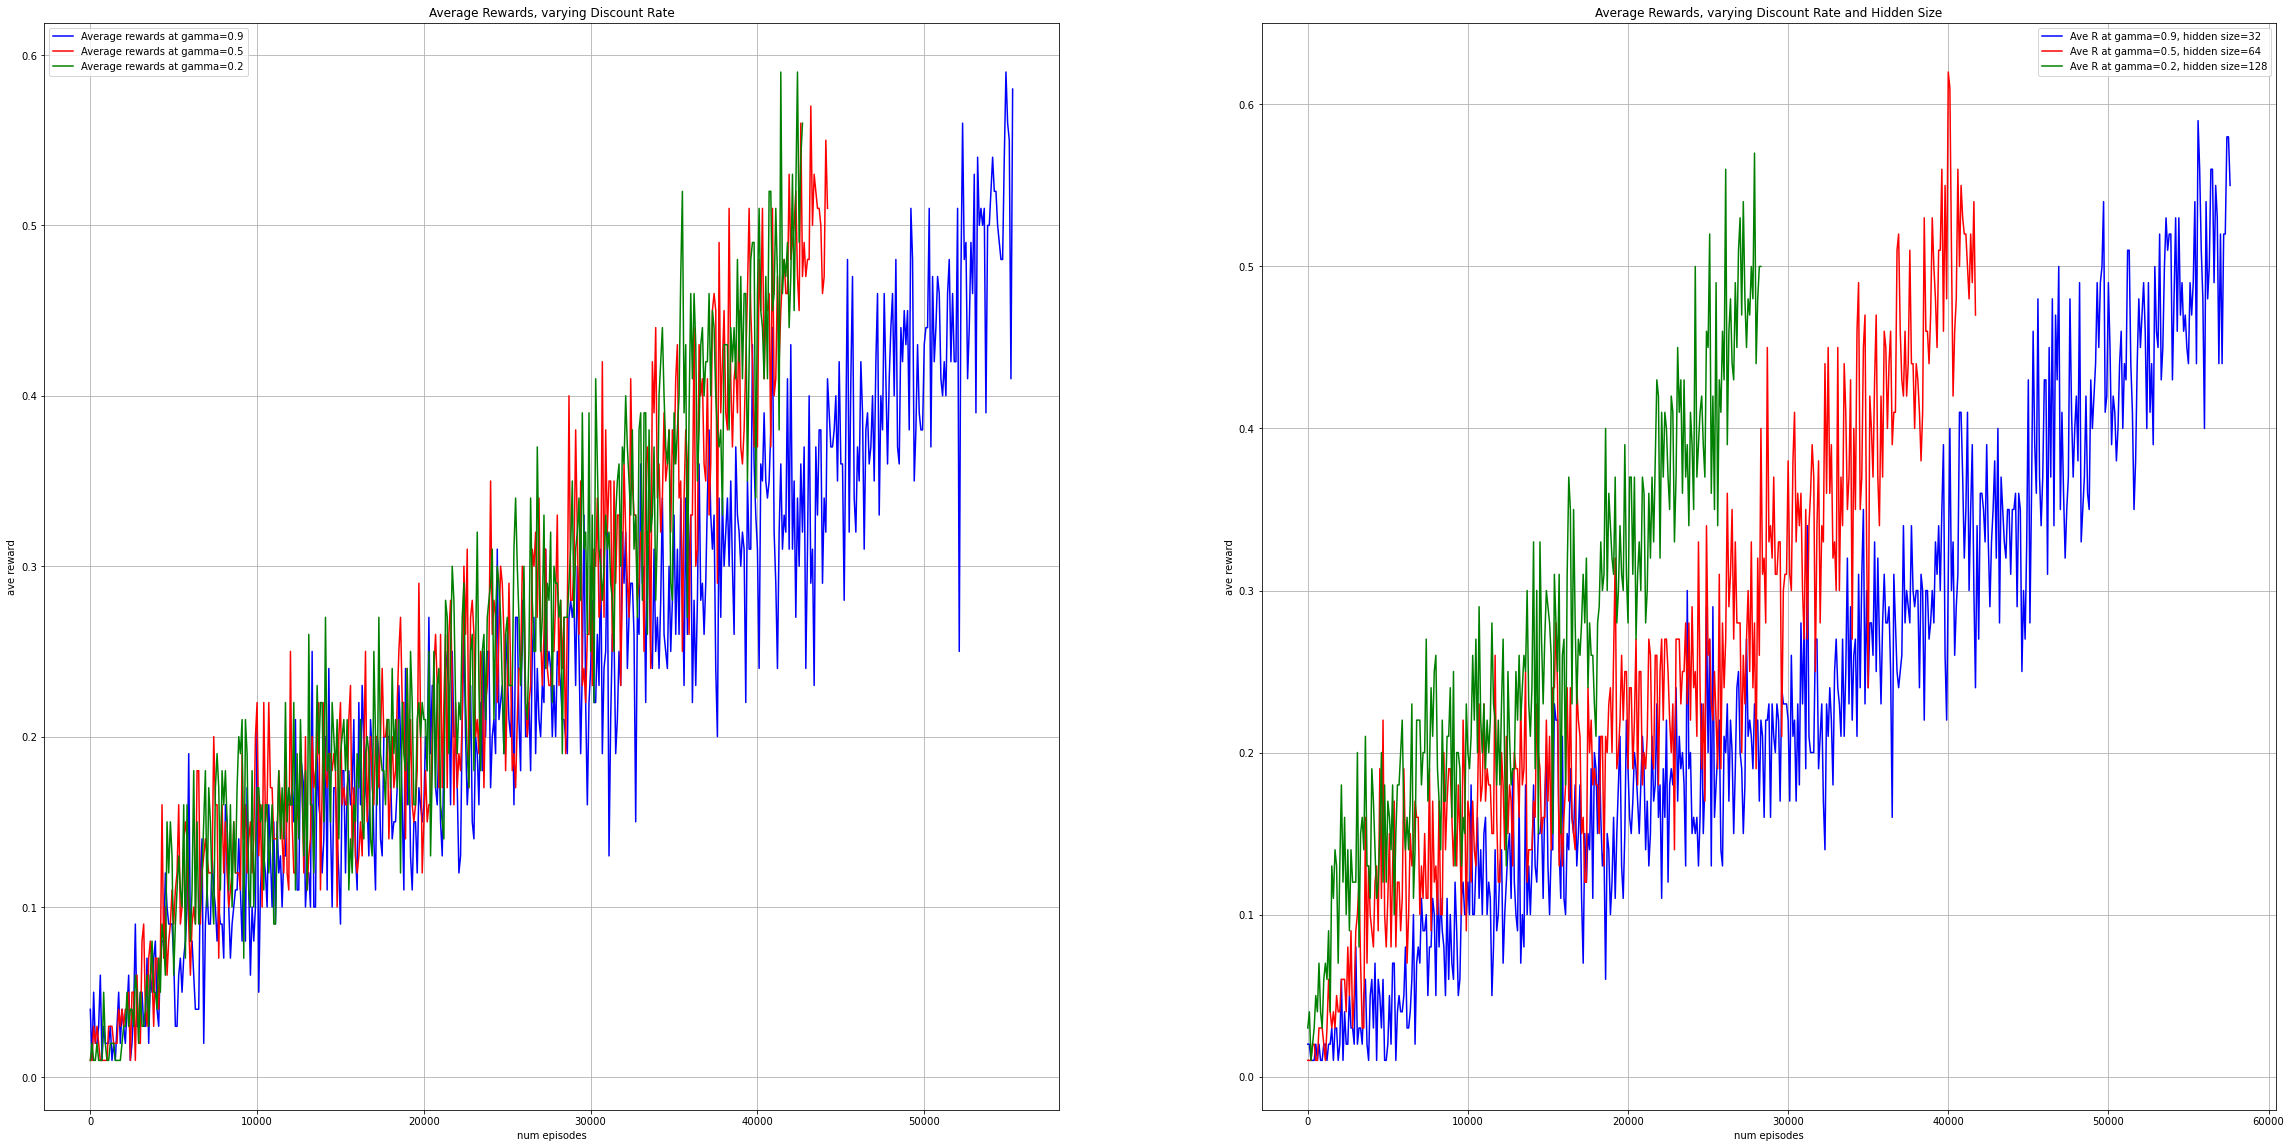

In [116]:

def main():
    env = gym.make('FrozenLake-v0', is_slippery=False)
    env = OneHotWrapper(env)

    obs_size = env.observation_space.shape[0]  # 16
    n_actions = env.action_space.n  # 4
    batch_size= 100
    percentile = 70
    reward_goal = 0.70
    plt.rcParams['figure.figsize'] = [40, 20]
    f, (sp1, sp2) = plt.subplots(1,2)

    gamma0 = 0.9
    net0 = Net(obs_size=obs_size, hidden_size=32, n_actions=n_actions)
    mean_rewards0 = cross_entropy(net0, env, gamma0, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards0)*batch_size) if e % batch_size== 0]
    sp1.plot(episodes,mean_rewards0, 'b', label='Average rewards at gamma={}'.format(gamma0))

    gamma1 = 0.5
    net1 = Net(obs_size=obs_size, hidden_size=64, n_actions=n_actions)
    mean_rewards1 = cross_entropy(net1, env, gamma1, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards1)*batch_size) if e % batch_size== 0]
    sp1.plot(episodes, mean_rewards1, 'r', label='Average rewards at gamma={}'.format(gamma1))

    gamma2 = 0.2
    net2 = Net(obs_size=obs_size, hidden_size=64, n_actions=n_actions)
    mean_rewards2 = cross_entropy(net2,env, gamma2, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards2)*batch_size) if e % batch_size== 0]
    sp1.plot(episodes, mean_rewards2, 'g', label='Average rewards at gamma={}'.format(gamma2))

    sp1.legend()
    sp1.set(xlabel='num episodes', ylabel='ave reward',
            title='Average Rewards, varying Discount Rate')
    sp1.grid()

    net3 = Net(obs_size=obs_size, hidden_size=32, n_actions=n_actions)
    gamma3 = 0.9
    mean_rewards3 = cross_entropy(net3, env, gamma3, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards3) * batch_size) if e % batch_size == 0]
    sp2.plot(episodes, mean_rewards3, 'b', label='Ave R at gamma={}, hidden size=32'.format(gamma0))

    net4 = Net(obs_size=obs_size, hidden_size=64, n_actions=n_actions)
    gamma1 = 0.5
    mean_rewards4 = cross_entropy(net4, env, gamma1, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards4) * batch_size) if e % batch_size == 0]
    sp2.plot(episodes, mean_rewards4, 'r', label='Ave R at gamma={}, hidden size=64'.format(gamma1))

    net5 = Net(obs_size=obs_size, hidden_size=128, n_actions=n_actions)
    gamma5 = 0.2
    mean_rewards5 = cross_entropy(net5, env, gamma5, batch_size, percentile, reward_goal)
    episodes = [e for e in range(0, len(mean_rewards5) * batch_size) if e % batch_size == 0]
    sp2.plot(episodes, mean_rewards5, 'g', label='Ave R at gamma={}, hidden size=128'.format(gamma2))

    sp2.legend()
    sp2.set(xlabel='num episodes', ylabel='ave reward',
           title='Average Rewards, varying Discount Rate and Hidden Size')
    sp2.grid()
    plt.show()


if __name__ == "__main__":
    main()